# SVM


In [1]:
import numpy as np
import sympy as sym
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

## Simple Example Application

对于简单的数据样本例子(也就是说可以进行线性划分,且不包含噪声点)

**算法:**

输入:线性可分训练集$T={(x_1,y_1),(x_2,y_2),...,(x_N,y_N)}$,其中$x_i \in \textit{X}=\textit{R},y_i \in \textit{Y}={+1,-1},i=1,2...,N$

输出:分离超平面和分类决策函数

(1) 构造并求解约束条件最优化问题

$\underset{\alpha}{min}$  $\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i \alpha_j y_i y_j <x_i \cdot x_j>-\sum_{i=1}^{N}\alpha_i$

s.t $\sum_{i=1}^{N}\alpha_i y_i=0$

$\alpha_i \geq  0,i=1,2,...,N$

求得最优$\alpha^{*}=(\alpha_1^{*},\alpha_2^{*},...,\alpha_n^{*})$


其中正分量$\alpha_j^{*}>0$就为支持向量

(2) 计算

$w^{*} = \sum_{i=1}^{N}\alpha_i^{*}y_ix_i$

选择$\alpha^{*}$的一个正分量$\alpha_j^{*}>0$,计算

$b^{*}=y_j-\sum_{i=1}^{N}\alpha_i^{*}y_i<x_i \cdot x_j>$



(3) 求得分离超平面

$w^{*}\cdot x + b^{*}=0$

分类决策函数:

$f(x)=sign(w^{*}\cdot x + b^{*})$

这里的sign表示:值大于0的为1,值小于0的为-1.

In [246]:
def loadSimpleDataSet():
    """
    从文本加载数据集
    
    返回:
        数据集和标签集
    """
    train_x = np.array([[3,3],[4,3],[1,1]]).T
    train_y = np.array([[1,1,-1]]).T
    return train_x,train_y

In [247]:
train_x,train_y = loadSimpleDataSet()
print("train_x shape is : ",train_x.shape)
print("train_y shape is : ",train_y.shape)

train_x shape is :  (2, 3)
train_y shape is :  (3, 1)


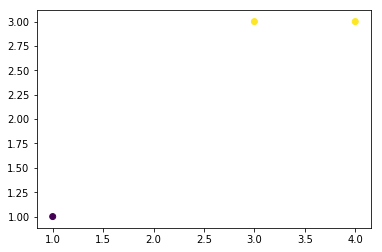

In [248]:
plt.scatter(train_x[0,:],train_x[1,:],c=np.squeeze(train_y))

为了方便计算$\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i \alpha_j y_i y_j <x_i \cdot x_j>$

我们需要先求出train_x、train_y、alphas的内积然后逐个元素相乘然后累加.

计算train_x的内积

In [249]:
Inner_train_x = np.dot(train_x.T,train_x)
print("Train_x is:\n",train_x)
print("Inner train x is:\n",Inner_train_x)

Train_x is:
 [[3 4 1]
 [3 3 1]]
Inner train x is:
 [[18 21  6]
 [21 25  7]
 [ 6  7  2]]


计算train_y的内积

In [250]:
Inner_train_y = np.dot(train_y,train_y.T)
print("Train y is:\n",train_y)
print("Inner train y is:\n",Inner_train_y)

Train y is:
 [[ 1]
 [ 1]
 [-1]]
Inner train y is:
 [[ 1  1 -1]
 [ 1  1 -1]
 [-1 -1  1]]


计算alphas(拉格朗日乘子)的内积,但是要注意,我们在这里固定拉格朗日乘子中的某两个alpha之外的其他alpha,因为根据理论知识,我们需要固定两个alpha之外的其他alphas,然后不断的再一堆alphas中去迭代更新这两个alpha.由于这个例子过于简单,且只有3个样本点(事实上$\alpha_1,\alpha_3$就是支持向量).


将约束条件带入其中:

$\sum_{i=1}^3\alpha_i y_i=\alpha_1y_1+\alpha_2y_2+\alpha_3y_3 =0 \Rightarrow $
--
$\alpha_3 = -(\alpha_1y_1+\alpha_2y_2)/y_3 $
--


In [251]:
alphas_sym = sym.symbols('alpha1:4')
alphas = np.array([alphas_sym]).T
alphas[-1]= -np.sum(alphas[:-1,:]*train_y[:-1,:]) / train_y[-1,:]
Inner_alphas = np.dot(alphas,alphas.T)
print("alphas is: \n",alphas)
print("Inner alphas is:\n",Inner_alphas)

alphas is: 
 [[alpha1]
 [alpha2]
 [1.0*alpha1 + 1.0*alpha2]]
Inner alphas is:
 [[alpha1**2 alpha1*alpha2 alpha1*(1.0*alpha1 + 1.0*alpha2)]
 [alpha1*alpha2 alpha2**2 alpha2*(1.0*alpha1 + 1.0*alpha2)]
 [alpha1*(1.0*alpha1 + 1.0*alpha2) alpha2*(1.0*alpha1 + 1.0*alpha2)
  (1.0*alpha1 + 1.0*alpha2)**2]]


现在求最优的$\alpha^{*}=(\alpha_1^{*},\alpha_2^{*},...,\alpha_n^{*})$

$\underset{\alpha}{min}$  $\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i \alpha_j y_i y_j <x_i \cdot x_j>-\sum_{i=1}^{N}\alpha_i$

**注意:**

这里需要使用sympy库,详情请见[柚子皮-Sympy符号计算库](https://blog.csdn.net/pipisorry/article/details/39123247)

或者[Sympy](https://www.sympy.org/en/index.html)

In [252]:
def compute_dual_function(alphas,Inner_alphas,Inner_train_x,Inner_train_y):
    """
    Parameters:
        alphas: initialization lagrange multiplier,shape is (n,1).
                n:number of example.
        Inner_alphas: Inner product of alphas.
        Inner_train_x: Inner product of train x set.
        Inner_train_y: Inner product of train y set.
        
    simplify : simplify compute result of dual function.
    
    return:
        s_alpha: result of dual function
    """
    s_alpha = sym.simplify(1/2*np.sum(Inner_alphas * Inner_train_x*Inner_train_y) - (np.sum(alphas)))
    return s_alpha


In [253]:
s_alpha = compute_dual_function(alphas,Inner_alphas,Inner_train_x,Inner_train_y)
print('s_alpha is:\n ',s_alpha)

s_alpha is:
  4.0*alpha1**2 + 10.0*alpha1*alpha2 - 2.0*alpha1 + 6.5*alpha2**2 - 2.0*alpha2


现在对每一个alpha求偏导令其等于0.

In [254]:
def Derivative_alphas(alphas,s_alpha):
    """
    Parameters:
                alphas: lagrange multiplier.
                s_alpha: dual function
                
    return:
            bool value.
            True: Meet all constraints,means,all lagrange multiplier >0
            False:Does not satisfy all constraints,means some lagrange multiplier <0.
    """
    cache_derivative_alpha = []
    for alpha in alphas.squeeze()[:-1]: # remove the last element.
        derivative = s_alpha.diff(alpha) # diff: derivative
        cache_derivative_alpha.append(derivative)
        
    derivative_alpha = sym.solve(cache_derivative_alpha,set=True) # calculate alphas.
    print('derivative_alpha is: ',derivative_alpha)
    
    # check alpha > 0
    check_alpha_np = np.array(list(derivative_alpha[1])) > 0
    
    return check_alpha_np.all()

In [255]:
check_alpha = Derivative_alphas(alphas,s_alpha)
print("Constraint lagrange multiplier is: ",check_alpha)

derivative_alpha is:  ([alpha1, alpha2], {(1.50000000000000, -1.00000000000000)})
Constraint lagrange multiplier is:  False


可以看出如果是对于$\alpha_2<0$,不满足$\alpha_2 \geqslant 0 $所以我们不能使用极值

-------------

由于在求偏导的情况下不满足拉格朗日乘子约束条件,所以我们将固定某一个$\alpha_i$,将其他的$\alpha$令成0,使偏导等于0求出当前$\alpha_i$，然后在带入到对偶函数中求出最后的结果.比较所有的结果挑选出结果最小的值所对应的$\alpha_i$,在从中选出$\alpha_i>0$的去求我们最开始固定的其他alphas.


**算法:**

输入: 拉格朗日乘子数组,数组中不包括最开始固定的其他alphas
输出: 最优的拉格朗日乘子,也就是支持向量

(1) 将输入的拉格朗日数组扩增一行或者一列并初始化为0
    - alphas_zeros = np.zeros((alphas.shape[0],1))[:-1]
    - alphas_add_zeros = np.c_[alphas[:-1],alphas_zeros]
(2) 将扩增后的数组进行"mask"掩模处理,目的是为了将一个$\alpha$保留,其他的$\alpha$全部为0.
    - mask_alpha = np.ma.array(alphas_add_zeros, mask=False) # create mask array.
    - mask_alpha.mask[i] = True # masked alpha
    - 在sysmpy中使用掩模处理会报出一个警告:将掩模值处理为None,其实问题不大,应该不会改变对偶方程中的alpha对象

(3) 使用掩模后的数组放入对偶函数中求偏导$\alpha_i$,并令其等于0求出$\alpha_i$
 
(4) 将求出的$\alpha_i$和其他都等于0的alphas带入到对偶函数中求出值

(5) 比较所有的对偶函数中的值,选取最小值所对应的alpha组.计算最开始固定值的alphas.


In [256]:

def choose_best_alphas(alphas,s_alpha):
    """
    Parameters:
                alphas: Lagrange multiplier.
                s_alpha: dual function
                
    return:
                best_vector: best support vector machine.
    """
    # add col in alphas,and initialize value equal 0. about 2 lines.
    alphas_zeros = np.zeros((alphas.shape[0],1))[:-1]
    alphas_add_zeros = np.c_[alphas[:-1],alphas_zeros]
    
    # cache some parameters.
    cache_alphas_add = np.zeros((alphas.shape[0],1))[:-1] # cache derivative alphas.
    cache_alphas_compute_result = np.zeros((alphas.shape[0],1))[:-1] # cache value in dual function result
    cache_alphas_to_compute = alphas_add_zeros.copy() # get minmux dual function value,cache this values.
    
    
    for i in range(alphas_add_zeros.shape[0]):
        mask_alpha = np.ma.array(alphas_add_zeros, mask=False) # create mask array.
        mask_alpha.mask[i] = True # masked alpha
        value = sym.solve(s_alpha.subs(mask_alpha).diff())[0] # calculate alpha_i
        
        cache_alphas_add[i] = value
        cache_alphas_to_compute[i][1] = value
        cache_alphas_compute_result[i][0] = s_alpha.subs(cache_alphas_to_compute) # calculate finally dual function result.
        cache_alphas_to_compute[i][1] = 0 # make sure other alphas equal 0.
        
   
    min_alpha_value_index = cache_alphas_compute_result.argmin()
    
    best_vector =np.array([cache_alphas_add[min_alpha_value_index]] +  [- cache_alphas_add[min_alpha_value_index] / train_y[-1]]) 
    
    
    return [min_alpha_value_index]+[2],best_vector


    

In [257]:
min_alpha_value_index,best_vector = choose_best_alphas(alphas,s_alpha)
print(min_alpha_value_index)
print('support vector machine is:',alphas[min_alpha_value_index])

[0, 2]
support vector machine is: [[alpha1]
 [1.0*alpha1 + 1.0*alpha2]]


/Users/huwang/anaconda3/lib/python3.6/site-packages/sympy/core/sympify.py:298: UserWarning: Warning: converting a masked element to nan.
  return sympify(coerce(a))


$w^{*} = \sum_{i=1}^{N}\alpha_i^{*}y_ix_i$


In [258]:
w = np.sum(np.multiply(best_vector , train_y[min_alpha_value_index].T) * train_x[:,min_alpha_value_index],axis=1)
print("W is: ",w)

W is:  [0.5 0.5]


选择$\alpha^{*}$的一个正分量$\alpha_j^{*}>0$,计算

$b^{*}=y_j-\sum_{i=1}^{N}\alpha_i^{*}y_i<x_i \cdot x_j>$

这里我选alpha1

In [259]:
b = train_y[0]-np.sum(best_vector.T * np.dot(train_x[:,min_alpha_value_index].T,train_x[:,min_alpha_value_index])[0] 
                      * train_y[min_alpha_value_index].T)
print("b is: ",b)

b is:  [-2.]


所以超平面为:

$f(x)=sign[wx+b]$

# SMO

这里实现简单版本的smo算法,这里所谓的简单版本指的是速度没有SVC快,参数自动选择没有SCV好等.但是通过调节参数一样可以达到和SVC差不多的结果

### 算法:

#### 1.SMO选择第一个变量的过程为选择一个违反KKT条件最严重的样本点为$\alpha_1$,即违反以下KKT条件:

$\alpha_i=0\Leftrightarrow y_ig(x_i)\geqslant1$

$0<\alpha_i<C\Leftrightarrow y_ig(x_i)=1$

$\alpha_i=C \Leftrightarrow y_ig(x_i)\leqslant1$

其中:

$g(x_i)=\sum_{j=1}^{N}\alpha_iy_iK(x_i,x_j)+b$

**注意:**
- 初始状态下$\alpha_i$定义为0,且和样本数量一致.
- 该检验是在$\varepsilon$范围内的
- 在检验过程中我们先遍历所有满足$0<\alpha_i<C$的样本点,即在间隔边界上的支持向量点,找寻违反KKT最严重的样本点
- 如果没有满足$0<\alpha_i<C$则遍历所有的样本点，找违反KKT最严重的样本点
- 这里的*违反KKT最严重的样本点*可以选择为$y_ig(x_i)$最小的点作为$\alpha_1$

#### 2.SMO选择第二个变量的过程为希望$\alpha_2$有足够的变化

因为$\alpha_2^{new}$是依赖于$|E_1-E_2|$的,并且使得|E_1-E_2|最大,为了加快计算,一种简单的做法是:

如果$E_1$是正的,那么选择最小的$E_i$作为$E_2$,如果$E_1$是负的,那么选择最大的$E_i$作为$E_2$,为了节省计算时间,将$E_i$保存在一个列表中

**注意:**
- 如果通过以上方法找到的$\alpha_2$不能使得目标函数有足够的下降,那么采用以下启发式方法继续选择$\alpha_2$,遍历在间隔边上的支持向量的点依次将其对应的变量作为$\alpha_2$试用,直到目标函数有足够的下降,若还是找不到使得目标函数有足够下降,则抛弃第一个$\alpha_1$,在重新选择另一个$\alpha_1$

- 这个简单版本的SMO算法并没有处理这种特殊情况






#### 3.计算$\alpha_1^{new},\alpha_2^{new}$

计算$\alpha_1^{new},\alpha_2^{new}$,是为了计算$b_i,E_i$做准备.

3.1 计算$\alpha_2$的边界:

- if $y_1 \neq y_2$:$L=max(0,\alpha_2^{old}-\alpha_1^{old})$,$H=min(C,C+\alpha_2^{old}-\alpha_1^{old})$

- if $y_1 = y_2$:$L=max(0,\alpha_2^{old}+\alpha_1^{old}-C)$,$H=min(C,C+\alpha_2^{old}+\alpha_1^{old})$

3.2 计算$\alpha_2^{new,unc} = \alpha_2^{old}+\frac{y_2(E_1-E_2)}{\eta}$

其中:

$\eta = K_{11}+K_{22}-2K_{12}$,这里的$K_n$值得是核函数,可以是高斯核,多项式核等.

3.3 修剪$\alpha_2$

$\alpha_2^{new}=\left\{\begin{matrix}
H, &\alpha_2^{new,unc}>H \\ 
 \alpha_2^{new,unc},& L\leqslant \alpha_2^{new,unc}\leqslant H \\ 
 L,& \alpha_2^{new,unc}<L
\end{matrix}\right.$

3.3 计算$\alpha_1^{new}$

$\alpha_1^{new}=\alpha_1^{old}+y_1y_2(\alpha_2^{old}-\alpha_2^{new})$

#### 4.计算阈值b和差值$E_i$

$b_1^{new}=-E_1-y_1K_{11}(\alpha_1^{new}-\alpha_1^{old})-y_2K_{21}(\alpha_2^{new}-\alpha_2^{old})+b^{old}$

$b_2^{new}=-E_2-y_1K_{12}(\alpha_1^{new}-\alpha_1^{old})-y_2K_{22}(\alpha_2^{new}-\alpha_2^{old})+b^{old}$

如果$\alpha_1^{new},\alpha_2^{new}$,同时满足条件$0<\alpha_i^{new}<C,i=1,2$,

那么$b_1^{new}=b_2^{new}=b^{new}$.

如果$\alpha_1^{new},\alpha_2^{new}$是0或者C,那么$b_1^{new},b_2^{new}$之间的数
都符合KKT条件阈值,此时取中点为$b^{new}$

$E_i^{new}=(\sum_sy_j\alpha_jK(x_i,x_j))+b^{new}-y_i$

其中s是所有支持向量$x_j$的集合.

#### 5. 更新参数

更新$\alpha_i,E_i,b_i$

#### 注意:

在训练完毕后,绝大部分的$\alpha_i$的分量都为0,只有极少数的分量不为0,那么那些不为0的分量就是支持向量

### SMO简单例子

加载数据,来自于scikit中的的鸢尾花数据,其每次请求是变化的

In [2]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
   
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()

# 划分训练样本和测试样本
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

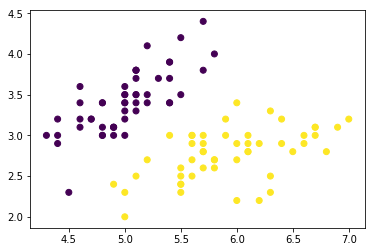

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

### 开始搭建SMO算法代码

In [19]:
class SVM:
    def __init__(self,max_iter = 100,kernel = 'linear',C=1.,is_print=False,sigma=1):
        """
        Parameters:
            max_iter:最大迭代数
            kernel:核函数,这里只定义了"线性"和"高斯"
            sigma:高斯核函数的参数
            C:惩罚项,松弛变量
            is_print:是否打印
            
        """
        
        self.max_iter = max_iter
        self.kernel = kernel
        self.C = C  # 松弛变量C
        self.is_print = is_print
        self.sigma = sigma
    def init_args(self,fetures,labels):
        """
        self.m:样本数量
        self.n:特征数
        """
        self.m,self.n = fetures.shape
        self.X = fetures
        self.Y = labels
        self.b = 0.
        
        # 将E_i 保存在一个列表中
        self.alpha = np.zeros(self.m) + 0.0001
        self.E = [self._E(i) for i in range(self.m)]

    def _g(self,i):
        """
        预测值g(x_i)
        
        """
        g_x = np.sum(self.alpha*self.Y*self._kernel(self.X[i],self.X)) + self.b
        return g_x
        
    
    def _E(self,i):
        """
        E(x) 为g(x) 对输入x的预测值和y的差值
        """
        g_x = self._g(i) - self.Y[i]
        return g_x
    
    
    def _kernel(self,x1,x2):
        """
        计算kernel
        """
        if self.kernel == "linear":
            return np.sum(np.multiply(x1,x2),axis=1)
        if self.kernel == "Gaussion":
            return np.sum(np.exp(-((x1-x2)**2)/(2*self.sigma)),axis=1)
    
    def _KKT(self,i):
        """
        判断KKT
        """
        y_g = np.round(np.float64(np.multiply(self._g(i),self.Y[i]))) # 存在精度问题也就是说在epsilon范围内,所以这里使用round

        if self.alpha[i] == 0:

            return y_g >= 1,y_g
        
        elif 0<self.alpha[i]<self.C:

            return y_g == 1,y_g
        
        elif self.alpha[i] == self.C:

            return y_g <=1,y_g
        
        else:
            return ValueError
        
    def _init_alpha(self):
        """
        外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT
        0<a<C的样本点为间隔边界上支持向量点
        """
        index_array = np.where(np.logical_and(self.alpha>0,self.alpha<self.C))[0] # 因为这里where的特殊性,所以alpha必须是(m,)

        if len(index_array) !=0:
            cache_list = []
            for i in index_array:
                bool_,y_g = self._KKT(i)
                if not bool_:
                    cache_list.append((y_g,i))
                    
        # 如果没有则遍历整个样本
        else:
            cache_list = []
            for i in range(self.m):
                bool_,y_g = self._KKT(i)
                if not bool_:
                    cache_list.append((y_g,i))
                
        #获取违反KKT最严重的样本点,也就是g(x_i)*y_i 最小的
        min_i = sorted(cache_list,key=lambda x:x[0])[0][1]
        
        # 选择第二个alpha2
        E1 = self.E[min_i]

        if E1 > 0:
            j = np.argmin(self.E)
        else:
            j = np.argmax(self.E)

        return min_i,j

    def _prune(self,alpha,L,H):
        """
        修剪alpha
        """
        if alpha > H:
            return H
        elif L<=alpha<=H:
            return alpha
        elif alpha < L:
            return L
        else:
            return ValueError
        
    
    def fit(self,features, labels):
        self.init_args(features, labels)
        for t in range(self.max_iter):
            # 开始寻找alpha1,和alpha2
            i1,i2 = self._init_alpha()
            
            # 计算边界
            if self.Y[i1] == self.Y[i2]: # 同号
                L = max(0,self.alpha[i2]+self.alpha[i1]-self.C)
                H = min(self.C,self.alpha[i2]+self.alpha[i1])
            else:
                L = max(0,self.alpha[i2]-self.alpha[i1])
                H = min(self.C,self.C+self.alpha[i2]-self.alpha[i1])


            # 计算阈值b_i 和差值E_i
            E1 = self.E[i1]
            E2 = self.E[i2]

            eta = self._kernel(self.X[np.newaxis,i1],self.X[np.newaxis,i1]) + \
                self._kernel(self.X[np.newaxis,i2],self.X[np.newaxis,i2]) - \
                2 * self._kernel(self.X[np.newaxis,i1],self.X[np.newaxis,i2])

            if eta <=0:
                continue

            alpha2_new_nuc = self.alpha[i2] + (self.Y[i2] * (E1-E2) /eta)
            # 修剪 alpha2_new_nuc
            alpha2_new = self._prune(alpha2_new_nuc,L,H)

            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2]-alpha2_new)


            # 计算b_i
            b1_new = -E1-self.Y[i1]*self._kernel(self.X[np.newaxis,i1],self.X[np.newaxis,i1])*(alpha1_new - self.alpha[i1])\
                        - self.Y[i2] * self._kernel(self.X[np.newaxis,i2],self.X[np.newaxis,i1])*(alpha2_new - self.alpha[i2]) + self.b
            b2_new = -E2-self.Y[i1]*self._kernel(self.X[np.newaxis,i1],self.X[np.newaxis,i2])*(alpha1_new - self.alpha[i1])\
                        - self.Y[i2] * self._kernel(self.X[np.newaxis,i2],self.X[np.newaxis,i2])*(alpha2_new - self.alpha[i2]) + self.b


            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2



            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            
            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
        
        if self.is_print:
            print("Train Done!")
         
    
    def predict(self,data):
        
        predict_y = np.sum(self.alpha*self.Y*self._kernel(data,self.X)) + self.b
        return np.sign(predict_y)[0]
                
    def score(self,test_X,test_Y):
        m,n = test_X.shape
        count = 0
        for i in range(m):
            predict_i = self.predict(test_X[i])
            if predict_i == np.float(test_Y[i]):
                count +=1
        return count / m    

由于鸢尾花数据每次请求都会变化,我们在这里取正确率的均值与SVC进行对比

In [15]:
count = 0
failed2 = []
for i in range(20):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    svm = SVM(max_iter=200,C=2,kernel='linear')
    svm.fit(X_train,y_train)
    test_accourate = svm.score(X_test,y_test)
    train_accourate = svm.score(X_train,y_train)
    
    if test_accourate < 0.8:
        failed2.append((X_train, X_test, y_train, y_test)) # 储存正确率过低的样本集
    print("Test accourate:",test_accourate)
    print("Train accourate:",train_accourate)
    print('--------------------------')
    count += test_accourate
print("Test average accourate is: ",count/20)

Test accourate: 0.6
Train accourate: 0.4666666666666667
--------------------------
Test accourate: 0.84
Train accourate: 0.7866666666666666
--------------------------
Test accourate: 0.96
Train accourate: 0.9333333333333333
--------------------------
Test accourate: 1.0
Train accourate: 0.8933333333333333
--------------------------
Test accourate: 0.96
Train accourate: 0.9733333333333334
--------------------------
Test accourate: 0.56
Train accourate: 0.5466666666666666
--------------------------
Test accourate: 0.96
Train accourate: 1.0
--------------------------
Test accourate: 0.84
Train accourate: 0.8266666666666667
--------------------------
Test accourate: 0.6
Train accourate: 0.7066666666666667
--------------------------
Test accourate: 0.92
Train accourate: 0.9466666666666667
--------------------------
Test accourate: 0.88
Train accourate: 0.9466666666666667
--------------------------
Test accourate: 0.76
Train accourate: 0.8533333333333334
--------------------------
Test accou

可以发现,有些数据的正确率较高,有些正确率非常的底,我们将低正确率的样本保存,取出进行试验

In [16]:
failed2X_train, failed2X_test, failed2y_train, failed2y_test= failed2[2]

我们可以看出,在更改C后,正确率依然是客观的,这说明简单版本的SMO算法是可行的.只是我们在测算
平均正确率的时候,C的值没有改变,那么可能有些样本的C值不合适.

In [17]:
svm = SVM(max_iter=200,C=5,kernel='linear')
svm.fit(failed2X_train,failed2y_train)
accourate = svm.score(failed2X_test,failed2y_test)
accourate

0.96

使用Scikit-SVC测试

### Scikit-SVC
基于scikit-learn的[SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function)

例子1:

In [18]:
from sklearn.svm import SVC
count = 0
for i in range(10):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    clf = SVC(kernel="linear",C=2)
    clf.fit(X_train, y_train)
    accourate = clf.score(X_test, y_test)
    print("accourate",accourate)
    count += accourate
print("average accourate is: ",count/10)

accourate 1.0
accourate 1.0
accourate 1.0
accourate 0.96
accourate 1.0
accourate 0.96
accourate 0.96
accourate 0.96
accourate 1.0
accourate 1.0
average accourate is:  0.984


当然由于是简单版本的SMO算法,所以平均正确率肯定没有SVC高,但是我们可以调节C和kernel来使得正确率提高

## Multilabel classification

多标签:一个实例可以有多个标签比如一个电影可以是动作,也可以是爱情.

多类分类(multi-class classification)：有多个类别需要分类，但一个样本只属于一个类别

多标签分类(multi-label classificaton)：每个样本有多个标签

对于多类分类，最后一层使用softmax函数进行预测，训练阶段使用categorical_crossentropy作为损失函数 

对于多标签分类，最后一层使用sigmoid函数进行预测，训练阶段使用binary_crossentropy作为损失函数

This example simulates a multi-label document classification problem. The dataset is generated randomly based on the following process:

- pick the number of labels: n ~ Poisson(n_labels)
- n times, choose a class c: c ~ Multinomial(theta)
- pick the document length: k ~ Poisson(length)
- k times, choose a word: w ~ Multinomial(theta_c)

In the above process, rejection sampling is used to make sure that n is more than 2, and that the document length is never zero. Likewise, we reject classes which have already been chosen. The documents that are assigned to both classes are plotted surrounded by two colored circles.

The classification is performed by projecting to the first two principal components found by [PCA](http://www.cnblogs.com/jerrylead/archive/2011/04/18/2020209.html) and [CCA](https://files-cdn.cnblogs.com/files/jerrylead/%E5%85%B8%E5%9E%8B%E5%85%B3%E8%81%94%E5%88%86%E6%9E%90.pdf) for visualisation purposes, followed by using the [sklearn.multiclass.OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier) metaclassifier using two SVCs with linear kernels to learn a discriminative model for each class. Note that PCA is used to perform an unsupervised dimensionality reduction, while CCA is used to perform a supervised one.

Note: in the plot, “unlabeled samples” does not mean that we don’t know the labels (as in semi-supervised learning) but that the samples simply do not have a label.

In [10]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


In [11]:
def plot_hyperplance(clf,min_x,max_x,linestyle,label):
    
    # get the separating heyperplance
    # 0 = w0*x0 + w1*x1 +b
    w = clf.coef_[0]
    a = -w[0] /w[1]
    xx = np.linspace(min_x -5,max_x + 5)
    yy = a * xx -(clf.intercept_[0]) / w[1] # clf.intercept_[0] get parameter b, 
    plt.plot(xx,yy,linestyle,label=label)

In [71]:
def plot_subfigure(X,Y,subplot,title,transform):
    if transform == "pca": # pca执行无监督分析(不注重label)
        
        X = PCA(n_components=2).fit_transform(X)
        print("PCA",X.shape)
        
    elif transform == "cca": # pca 执行监督分析(注重label),也即是说会分析label之间的关系
        X = CCA(n_components=2).fit(X, Y).transform(X)
        print("CCA",X.shape)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear')) # 使用 one -reset 进行SVM训练
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0]) # 找到第一类的label 索引
    
    one_class = np.where(Y[:, 1]) # 找到第二类的
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')
    

    # classif.estimators_[0]，获取第一个估算器,得到第一个决策边界
    plot_hyperplance(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    # classif.estimators_[1]，获取第二个估算器,得到第一个决策边界
    plot_hyperplance(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")

**make_multilabel_classification:**

make_multilabel_classification(n_samples=100, n_features=20, n_classes=5, n_labels=2, length=50, allow_unlabeled=True, sparse=False, return_indicator='dense', return_distributions=False, random_state=None)

Original: (100, 20)
CCA (100, 2)
PCA (100, 2)
Original: (100, 20)
CCA (100, 2)
PCA (100, 2)


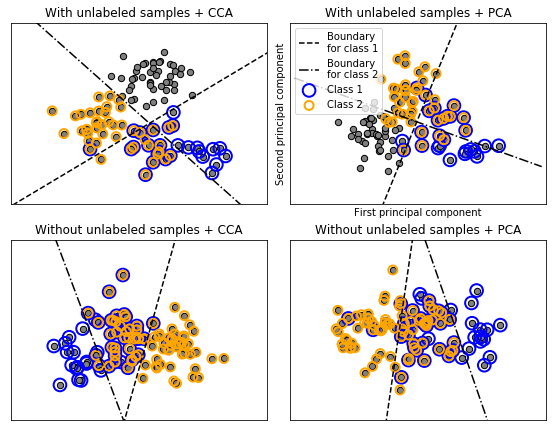

In [76]:
plt.figure(figsize=(8, 6))
    
# If ``True``, some instances might not belong to any class.也就是说某些实例可以并不属于任何标签([[0,0]]),使用hot形式
X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                  allow_unlabeled=True,
                                  random_state=1)

print("Original:",X.shape)
plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")


X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                  allow_unlabeled=False,
                                  random_state=1)

print("Original:",X.shape)
plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
plt.show()

由于是使用多标签(也就是说一个实例可以有多个标签),无论是标签1还是标签2还是未知标签(“没有标签的样本”).图中直观来看应该是CCA会由于PCA(无论是有没有采用"没有标签的样本"),因为CCA考虑了label之间的关联.

因为我们有2个标签在实例中,所以我们能够绘制2条决策边界(使用classif.estimators_[index])获取,并使用$x_1 = \frac{w_0}{w_1}x_1-\frac{b}{w_1}$绘制决策边界